## Lab 7: Hough Transform for line detection

Written by: Enrique Mireles Gutiérrez  
ID Number: 513944  
Bachelor: ITR  
Date: 2019-03-18  

### Introduction

Line detection is essential for autonomous vehicles. It is the basis for detecting lanes. At the core of it, lies the algorithm used for line detection known as Hough Transform. This algorithm uses the output of an edge detection algorithm to determine which points correspond to a line given a set of thresholds.  Then these lines can be used to determine which of them belong to the left and right lane. Nonetheless, before using the Hough Transform, the image must be prepared in order to obtain the best results. A basic pipeline for this uses Gaussian blur, Canny Edge detection, and a Region of Interest. All of these topics where discussed in previous lab reports.

The lane detection algorithms were simplified into different functions found in section 3. Moreover, the implementation used in this report uses the Probabilistic Hough Transform, which produces faster results by analyzing a random set of points instead of all points found in an image.

### Objectives

In this lab, you will learn about how to extract lines and circles from images using the Hough transform. Detection of features is an important part of image analysis and visual pattern recognition. Of particular interest is the identification of straight lines in images, as these appear in built indoor and outdoor environments as well as in manufactured parts. Hence, detecting lines in images play an important role in inspection, quality assessment, object detection, robot and vehicle navigation, etc.

### Procedure

This lab report is subdivided in smaller numbered programs shown below.

#### 1. Importing Libraries

The following libraries are used throughout the lab report:
- cv2: OpenCV library used for artificial vision.
- matplotlib: Create plots. Requires images in RGB color space.
- numpy: Library used for matrix operations.
- time: Library used to create time delays.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

#### 2. Constant definitions

The following lines define the constants used throughout the lab report:

In [2]:
HIGHWAY = '../fig/highway.jpg'
TRACK_VIDEO = '../fig/videos/running_track.mp4'
HIGHWAY_VIDEO = '../fig/videos/highway.mp4'

#### 3. Useful functions

The following functions are used several times. In order to avoid repetition they are defined here.

In [3]:
def is_grayscale(img):
    """
        Returns true if the image is grayscale (channels == 1).
        Returns false if channels > 1.
    """
    
    # If img.shape has a channel value, read it and determine if
    # it is a grayscale image. If it doesn't have, assume that the
    # image is grayscale.
    if (len(img.shape) == 3):
        return img.shape[2] == 1
    return True

def visualize_image(img, fig_number, fig_title, size=(16, 5), axis=False):
    """
        Plot image to a matplotlib figure.
    """
    
    # Select the figure.
    plt.figure(fig_number, figsize=size)
    
    # Determine the channels of the image and plot accodingly.
    if (is_grayscale(img)):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    
    # Set plot labels.
    plt.title(fig_title)
    if (axis):
        plt.xlabel('x-resolution')
        plt.ylabel('y-resolution')
    else:
        plt.axis('off')

def read_image_safe(filename, color, conversion=False):
    """
        Read an image in specified color space.
        If the image cannot be opened then exit the program and alert the user.
        Do a color space conversion if specified by the user.
    """
    
    # Read image and if it fails exit.
    img = cv2.imread(filename, color)
    if img is None:
        print('ERROR: image ', filename, 'could not be read')
        exit()
    
    # Do conversion if requested. Return image.
    if conversion:
        return cv2.cvtColor(img, conversion)
    return img

def create_roi(img, vertices):
    """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
    """
    
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if is_grayscale(img):
        ignore_mask_color = 255
    else:
        ignore_mask_color = (255, 255, 255)

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    return cv2.bitwise_and(img, mask)

def findLanes(hough_lines, img, settings):
    """
        Given an array of hough lines, detects which lines correspond to the left and right lane.
    """

    # Empty arrays for storing line coordinates (sets of points (x, y)).
    right_lines = {
        'x': [],
        'y': []
    }
    left_lines = {
        'x': [],
        'y': []
    }
    
    # Stores the fitted line coordinates for both lanes.
    # Its format is [x0, y0, x1, y1].
    lanes = {
        'left': [],
        'right': []
    }
    
    # Make sure at least some lines have been detected.
    if (type(hough_lines) == type(np.array([]))):

        # Iterate through every line.
        for line in hough_lines:

            # Usualy every line object contains a single set of coordinates,
            # nonetheless, it is placed inside a for for safety.
            for x1, y1, x2, y2 in line:

                # Calculate the direction of the line found.
                direction = np.rad2deg(np.arctan2(y2 - y1, x2 - x1))

                # Only draw lines whose angle is greater than the threshold.
                if (np.abs(direction) > settings['abs_min_line_angle']):

                    # If lines have a positive direction they are from the
                    # right lane.
                    if (direction > 0):
                        # Right lane.
                        right_lines['x'].extend([x1, x2])
                        right_lines['y'].extend([y1, y2])
                        if (settings['show_all_hough_lines']): 
                            cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
                    else:
                        # Left lane.
                        left_lines['x'].extend([x1, x2])
                        left_lines['y'].extend([y1, y2])
                        if (settings['show_all_hough_lines']):
                            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
                    
                    # Write the angle of the line for debugging purposes.
                    if (settings['show_all_hough_lines']): cv2.putText(img, '%.1f' % (direction), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255, 255, 0), thickness=1)
    
    # Make sure points on the left side were found.
    if (len(left_lines['x']) > 0 and len(left_lines['y']) > 0) and not settings['show_all_hough_lines']:
        
        # Using the points found, find a 1st order polynomial that best fits the data.
        poly_left = np.poly1d(np.polyfit(left_lines['y'], left_lines['x'], deg=1))
        
        # Evaluate the function found for the desired lane lengths.
        lanes['left'] = [
            int(poly_left(settings['lane_min_y'])),
            settings['lane_min_y'],
            int(poly_left(settings['lane_max_y'])),
            settings['lane_max_y']
        ]
    
    # Make sure points on the right side were found.
    if (len(right_lines['x']) > 0 and len(right_lines['y']) > 0) and not settings['show_all_hough_lines']:
        
        # Using the points found, find a 1st order polynomial that best fits the data.
        poly_right = np.poly1d(np.polyfit(right_lines['y'], right_lines['x'], deg=1))
        
        # Evaluate the function found for the desired lane lengths.
        lanes['right'] = [
            int(poly_right(settings['lane_min_y'])), 
            settings['lane_min_y'], 
            int(poly_right(settings['lane_max_y'])), 
            settings['lane_max_y']
        ]

    return lanes

def drawLanes(lanes, img):
    """
        Given the output of findLanes, draws the lanes in the image.
    """
    
    if (len(lanes['left'])):
        cv2.line(img, (lanes['left'][0], lanes['left'][1]), (lanes['left'][2], lanes['left'][3]), (0, 0, 255), 2)
    
    if (len(lanes['right'])):
        cv2.line(img, (lanes['right'][0], lanes['right'][1]), (lanes['right'][2], lanes['right'][3]), (0, 0, 255), 2)

def findLines(img, settings):
    """
        Given an BGR image, finds all lines in the image using a Probabilistic Hough Transform.
    """
    
    # Convert to gray scale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Blur image so that the Canny edge detector doesn't find useless edges.
    blur_gray = gray
    for i in range(settings['blur_iterations']):
        blur_gray = cv2.GaussianBlur(blur_gray, (settings['blur_kernel_size']), sigmaX=0, sigmaY=0)
    
    # Detect edges and create a ROI for the section defined.
    edges = cv2.Canny(blur_gray, settings['canny_low_threshold'], settings['canny_high_threshold'], apertureSize=3)
    masked_edges = create_roi(edges, settings['roi_vertices'].astype(int))
    
    # Detect lines.
    hough_lines = cv2.HoughLinesP(
        masked_edges, 
        rho = settings['hough_rho'], 
        theta = settings['hough_theta'], 
        threshold = settings['hough_threshold'], 
        lines = np.array([]), 
        minLineLength = settings['hough_min_line_length'], 
        maxLineGap = settings['hough_min_line_length']
    )
    
    # Return all data.
    return  {
        'gray': gray,
        'blur_gray': blur_gray,
        'edges': edges,
        'masked_edges': masked_edges,
        'hough_lines': hough_lines
    }

#### 4. Line detection on an image

The following section show step by step the process for detect lines in an image.

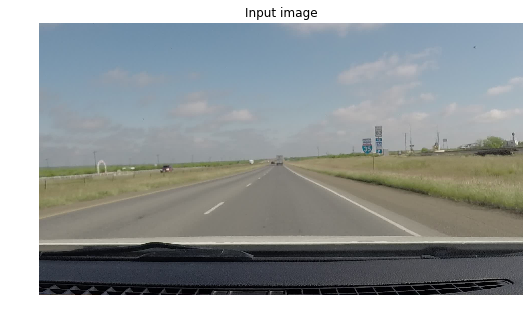

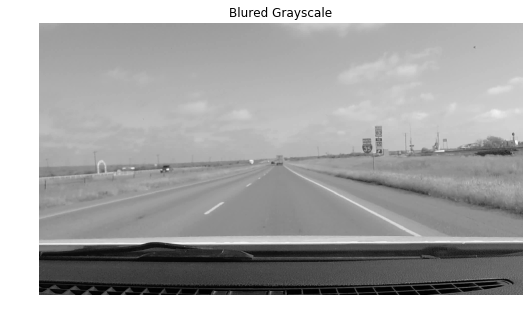

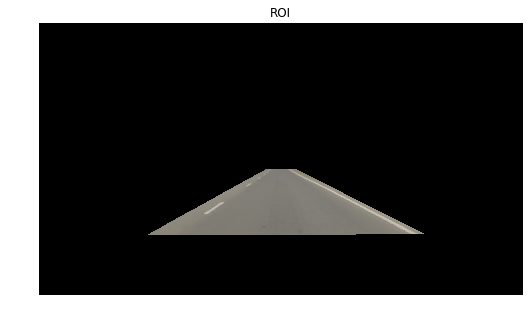

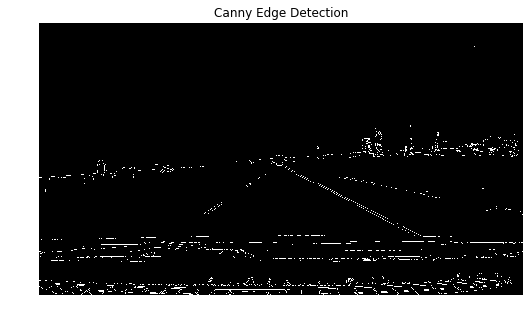

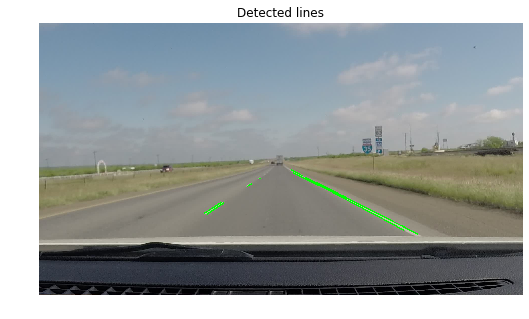

In [4]:
def run_pipeline(img_name):

    # Read image
    img_colour_rgb = read_image_safe(img_name, cv2.IMREAD_COLOR, cv2.COLOR_BGR2RGB)
    
    # Convert from BGR to RGB then from RGB to greyscale
    grey = cv2.cvtColor(img_colour_rgb, cv2.COLOR_RGB2GRAY)

    # Apply Gaussuan smoothing
    kernel_size = (7,7)
    blur_grey = cv2.GaussianBlur(grey, kernel_size, sigmaX=0, sigmaY=0)

    # Apply Canny edge detector
    low_threshold = 10
    high_threshold = 70
    edges = cv2.Canny(blur_grey, low_threshold, high_threshold, apertureSize=3)

    # Define a polygon-shape like region of interest
    bottom_left = (430, 840)
    top_left = (900, 580)
    top_right = (1020, 580)
    bottom_right = (1530, 838)
    vertices = np.array([[bottom_left,top_left, top_right, bottom_right]], dtype=np.int32)

    # Get a region of interest using the just created polygon. This will be
    # used together with the Hough transform to obtain the estimated Hough lines
    masked_image = create_roi(img_colour_rgb, vertices)
    masked_edges = create_roi(edges, vertices)

    # Apply Hough transform for lane lines detection
    rho = 1                       # distance resolution in pixels of the Hough grid
    theta = np.pi/180             # angular resolution in radians of the Hough grid
    threshold = 40                # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5              # minimum number of pixels making up a line
    max_line_gap = 5              # maximum gap ibn pixels between connectable line segments
    line_image = np.zeros_like(img_colour_rgb)   # creating a blank to draw lines on
    hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    # Visualise input and output images
    img_colour_with_lines = img_colour_rgb.copy()
    for line in hough_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img_colour_with_lines, (x1, y1), (x2, y2), (0,255,0), 3)

    # Visualise input and output images
    visualize_image(img_colour_rgb, 1, 'Input image')
    visualize_image(blur_grey, 2, 'Blured Grayscale')
    visualize_image(masked_image, 3, 'ROI')
    visualize_image(edges, 4, 'Canny Edge Detection')
    visualize_image(img_colour_with_lines, 5, 'Detected lines')

run_pipeline(HIGHWAY)

#### 5. Lane detection for videos

The following three sections detect lanes in videos. A settings object defines the values the algorithms will use and depend on the selected video. A single settings cell must be run before running the third cell.

This code uses the following functions from the __Useful functions__ section. Doing so greatly reduces the extension of the code. These include:
- `findLines`
- `findLanes`
- `drawLanes`

In [5]:
# Settings for the highway video.
settings = {
    'video_file': HIGHWAY_VIDEO,
    'scale': 1,
    'blur_kernel_size': (7, 7),
    'blur_iterations': 1,
    'canny_low_threshold': 10,
    'canny_high_threshold': 40,
    'hough_rho': 1,
    'hough_threshold': 20,
    'hough_theta': np.pi / 180,
    'hough_min_line_length': 5,
    'hough_max_line_gap': 60,
    'show_all_hough_lines': False,
    'roi_vertices': np.array([[
        (430, 830),           # Bottom left roi coordinate.
        (900, 600),           # Top left roi coordinate.
        (1020, 600),          # Top Right roi coordinate.
        (1530, 830)           # Bottom right roi coordinate.
    ]]) * 0.5,
    'abs_min_line_angle': 20,
    'lane_min_y': int(600 * 0.5),
    'lane_max_y': int(830 * 0.5)
}

In [6]:
# Settings for the track video.
settings = {
    'video_file': TRACK_VIDEO,
    'scale': 1,
    'blur_kernel_size': (7, 7),
    'blur_iterations': 2,
    'canny_low_threshold': 20,
    'canny_high_threshold': 80,
    'hough_rho': 1,
    'hough_threshold': 20,
    'hough_theta': np.pi / 180,
    'hough_min_line_length': 5,
    'hough_max_line_gap': 60,
    'show_all_hough_lines': False,
    'roi_vertices': np.array([[
        (0, 800),           # Bottom left roi coordinate.
        (100, 350),         # Top left roi coordinate.
        (1820, 350),        # Top Right roi coordinate.
        (1920, 800)         # Bottom right roi coordinate.
    ]]) * 0.5,
    'abs_min_line_angle': 20,
    'lane_min_y': int(350 * 0.5),
    'lane_max_y': int(850 * 0.5)
}

In [7]:
# Open selected video file.
cap = cv2.VideoCapture(settings['video_file'])

# Get scaled video properties.
FRAME_WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * settings['scale'])
FRAME_HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * settings['scale'])
FRAME_FPS = cap.get(cv2.CAP_PROP_FPS)

# Create input and ROI windows. Place each window side by side.
cv2.namedWindow('input', cv2.WINDOW_AUTOSIZE)
cv2.moveWindow('input', 0, 200)
cv2.namedWindow('ROI', cv2.WINDOW_AUTOSIZE)
cv2.moveWindow('ROI', FRAME_WIDTH, 200)

# Open video.
while(cap.isOpened()):
    
    # Read frame form video.
    ret, frame = cap.read()
    
    # If video ended exit.
    if ret:
        # Resize frame to desired scale.
        if (settings['scale'] != 1):
            img = cv2.resize(frame, (0, 0), fx=settings['scale'], fy=settings['scale'])
        else:
            img = frame
        
        # Find all lines in the image.
        output = findLines(img, settings)
        
        # With the lines found, find which of them belong to the left and right lanes.
        lanes = findLanes(output['hough_lines'], img, settings)
        
        # Draw results.
        drawLanes(lanes, img)
        cv2.imshow('input', img)
        cv2.imshow('ROI', output['masked_edges'])
    else:
        break
        
    # If 'q' is pressed, then exit.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# Clear memory and windows.
cap.release()
cv2.destroyAllWindows()

### Conclusions

This lab practice successfully detect the lanes in both videos. A couple of leaning points are important to mention. These include:
- The ROI cannot be done before performing Canny Edge detection. The reason behind this is that when a ROI is calculated, sharp edges are created, and thus detected by the Canny Edge detection algorithm. This is unwanted.

- Blurring before performing Canny Edge detection is essential for good lane detection. Blurring removes unwanted noise. Moreover, it was found that blurring several times yielded better results for Canny Edge detection, as the noise was further reduced, especially when using the `TRACK_VIDEO`.

- A settings dictionary was created to hold all settings for both videos. This made modifying values easier and made the code smaller because both videos used the same algorithms with different settings.

- When configuring the setting `show_all_hough_lines` to `True`, instead of showing the lanes, the algorithm show all lines found by the Hough Transform and their respective angles in degrees. This was useful for determining a good threshold value for the line angles. <img src='line_angle_examples.png' alt='Output of Hough Transform with calculated angles.'>

- Before getting the Hough Transform to work it was essential for Canny Edge detection to work correctly. This is the reason for displaying the edges with the output image. The following image shows that the lanes are detected on the right image, but not on the left image. This implies that the Canny Edge detector has good threshold values, but the Hough Transform doesn’t. Therefore, those values must be tweaked. <img src='bad_houghlines_config.png' alt='Wrong threshold values for Hough Transform.'>
      

It was found that the settings for one video completely failed for the other. Several factors lead to these differences. A key difference is that the ROI for both cameras is different. Moreover, the surface on which the cars run have different colors and surface types. The track road is noisier, meanwhile the highway is smoother.

Finally, the algorithm to determine which lines belong to the lanes worked exceptionally. The threshold angle discarded all horizontal lines and lines found on other lanes. Horizontal lines have smaller angles, and other lanes other than the main one have smaller angles. This filtering method proved itself to be really useful.
<img src='track_horizontal_lines.png' alt='Lines with small angles are not detected.'>
      
All in all, this algorithm works, nonetheless it feels a bit over-fitted. Lighting conditions, camera position, road condition, and many other factors, all determine the effectivity of the algorithms. A more robust algorithm must be proposed. At least it should have some memory for when lanes fail to be detected. Further development should also include probabilistic models to determine which detected lines correspond to the center lanes. Finally, instead of detecting edges on the gray scale image, the possibility of find edges in the Luma and Saturation channels could yield better results, that do no depend on road color.

_I hereby affirm that I have done this activity with academic integrity._